In [1]:
#Required Libraries.
library(rvest)
library(httr)
library(ggplot2)
library(reshape2)


Loading required package: xml2


# Table of Contents
 <p><div class="lev1 toc-item"><a href="#The-Problem" data-toc-modified-id="The-Problem-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Problem</a></div><div class="lev1 toc-item"><a href="#Getting-the-Data" data-toc-modified-id="Getting-the-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Getting the Data</a></div><div class="lev2 toc-item"><a href="#Getting-Started" data-toc-modified-id="Getting-Started-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Getting Started</a></div><div class="lev2 toc-item"><a href="#Scraping-Our-First-Page" data-toc-modified-id="Scraping-Our-First-Page-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Scraping Our First Page</a></div><div class="lev2 toc-item"><a href="#Scraping-with-httr-and-Regular-Expressions" data-toc-modified-id="Scraping-with-httr-and-Regular-Expressions-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Scraping with httr and Regular Expressions</a></div><div class="lev2 toc-item"><a href="#Extracting-Movie-Info" data-toc-modified-id="Extracting-Movie-Info-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Extracting Movie Info</a></div><div class="lev1 toc-item"><a href="#Data-Cleaning-&amp;-Exploration" data-toc-modified-id="Data-Cleaning-&amp;-Exploration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Cleaning &amp; Exploration</a></div><div class="lev2 toc-item"><a href="#Preliminary-Questions" data-toc-modified-id="Preliminary-Questions-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Preliminary Questions</a></div><div class="lev2 toc-item"><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data Cleaning</a></div><div class="lev2 toc-item"><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Data Exploration</a></div>

# The Problem

<p> Recently there has been a string of movies where there is a strong mismatch between the critical reception and audience reception. For example, _Get Out_ recieved wide critical aclaim, with 99% of critical reviews being positive; however, only 88% of general audience reviews were positive. 88% is still a very good score, but an 11 point difference between critical and general audiences seems quite large to me. This made me wonder how frequently critics and general audiences are in disagreement on the quality of a movie, and what factors may be associated with this mismatch.</p>

<p>For this project, I will be looking at movies released in the last decade (movies released between January 1, 2006 and January 1, 2017), and identifying which movies have a score difference of 10 points or more between top critics and all critics on Rotten Tomatoes. I will then cull text data from the reviews as well as movie data from IMDB to see if I can find any patterns among movies for which there is a disconnect between critics and online reviewers.</p>

# Getting the Data

<p>_To create a better user experience, I have made various versions of my data set available for download. If you want to run a snippet of code, you do not have to run all of my code from scratch. Simply scroll up and look for the last version of my data set available for download._ </p>

## Getting Started

<p>There are several libraries which allow one to scrape web data on R, but I will be using the rvest library. It has a very clean and compact design, easy to use selectr tools, and the magittr funcionality allows you to write very elegant code. Magittr allows you to use "%>%" to push an object forward to the next function, allowing you to write code with fewer named arguments. I learned how to use the rvest library by going through this tutorial at <a href="https://www.analyticsvidhya.com/blog/2017/03/beginners-guide-on-web-scraping-in-r-using-rvest-with-hands-on-knowledge/">analyticsvidhya.com</a>, but I will also describe the steps I took in using rvest here. </p>

<p>Because we are creating our own data, our first step is to decide what data we want and how we should get it. The easiest option would be to just look at the <a href="https://www.rottentomatoes.com/top/bestofrt/">"Top 100"</a> lists for each genre on Rotten Tomatoes and copy the tables. However, that would limit my exploration to movies that are highly critically acclamed. And while that focused approach could have value, I'd rather look at a broader set of movies. Instead, I decide that I will try to scrape movie information for all movies made in the last 10 years. Unfortunately, Rotten Tomatoes doesn't order its movies by year, which means I have to jump through a few hoops to get my desired data set. As a workaround, I will be using Wikipedia to generate a list of movies created in the last 10 years, since Wikipedia has a fairly comprehensive list of movies released for every calender year.</p>

## Scraping Our First Page 

Now that I know what I want to do, I will create a list of pages to scrape. Since all of the pages I want to scrape follow a pattern, I can use the paste command to generate my list of pages.

In [ ]:
WikipediaURLs = paste("https://en.wikipedia.org/wiki/", 2006:2016, "_in_film", sep = "")

<p>For each page in my list, I will use read_html to convert the web page into an R data frame. html_nodes then allows you to specify which objects you want with css or xpath selectors. The tutorial I linked to earlier advises you to use the SelectorGadget extension on Chrome to figure out the xpath or css selector that you want to use, but I found the SelectorGadget to be pretty finicky. I found it easier to use the inspect element tool available on most browsers: With this method, you right click on the element you want to extract and click "inspect." You should see the corresponding html code appear highlighted on the right. Right click on the highlighted html code and choose copy xpath or copy selector as desired. This will give you the exact path for the specific element you clicked on. Removing numerical information from your path generalizes it, so that it applies to similar elements. Bellow you can see pictures of me doing this for the Wikipedia pages I am scraping.</p> 

<p>If tags create results that are too broad, you can further specify your results by specifying attributes or IDs. For instance, here I use the html_attr function to specify I that want nodes marked as titles.</p>

In [ ]:
Titles = lapply(WikipediaURLs, function(i) {
    read_html(i) %>% html_nodes(xpath = "//*[contains(concat( \" \", @class, \" \" ), concat( \" \", \"wikitable\", \" \" ))]//i//a") %>% 
        html_attr("title")
})

Titles = unlist(Titles)

<p>This gives me the list of movie titles I wanted. Unfortunately, converting that list of titles into a list of Rotten Tomatoes URLs was harder than I anticipated. Initially I thought I could apply a simple rule to turn a title into a URL or use Rotten Tomoatoes' search function to generate my list of URLs. But no such rule exists, and Rotten Tomatoes' search function has wasn't robust enough to do the job.</p>

<p>I then tried to obtain a list of Rotten Tomatoes URLs by automating a Google search of Rotten Tomatoes + {movie title} and harvesting the top result. But as I later discovered, Google has protections in place to keep people from doing just this kind of thing (though people do get around it). At the end of the day, I decided that it was too impractical to write a scraping script that didn't get flagged down by Google, and that I should look for a better solution. After taking a break from the problem, I realized that most of Wikipedia's movie pages have an _External Links_ section that contain links to movie's Rotten Tomatoe's page. So all I had to do was get a list of individual Wikipedia movie pages, and harvest each page's _External Links_ section to get what I want. </p>

<p> Getting the list of Wikipedia movie pages is essentially the same as getting my list of titles. The only difference is that I am now harvesting nodes with the attribute "href" instead of "title." so I can reuse my code from the previous section. </p>


In [ ]:
Links = lapply(WikipediaURLs, function(i) {
    read_html(i) %>% html_nodes(xpath = "//*[contains(concat( \" \", @class, \" \" ), concat( \" \", \"wikitable\", \" \" ))]//i//a") %>% 
        html_attr("href")
})

Links = unlist(Links)

<p>Looking over my results, it looks like there are some redundant links. So I'm going to combine my columns into a data frame, and remove repeat entries. </p>

In [ ]:
MovieTable = data.frame(Title = Titles, WikipediaLink = paste("https://en.wikipedia.org", Links, sep = ""), stringsAsFactors = FALSE)
MovieTable = unique(MovieTable)

## Scraping with httr and Regular Expressions

 <p> The first time I tried to collect the Rotten Tomatoes links, my code broke halfway through because one of the Wikipedia URLs I had collected in the previous step had a connection error. To fix this, I used the httr library, which allows me to retrieve information from a URL. I can then tell my code not to run on pages that produce a connection error. If the connection is valid, the code will add the URL it extracts to a collumn I created called "RottenTomatoesLink". At this point, the steps I took were the same: I found a link that I wanted and used the inspect element feature to find its xpath, and generalized its xpath as appropriate. However, because this method will return multiple external links, I also have to use regular expressions to make sure I am only getting external links from Rotten Tomatoes.</p>


In [ ]:
MovieTable$RottenTomatoesLink = NA

for (i in seq(nrow(MovieTable))) {
    Connection = GET(MovieTable$WikipediaLink[i])
    if (status_code(Connection) <= 300) {
        Link = read_html(MovieTable$WikipediaLink[i]) %>% html_nodes(xpath = "//*[@id=\"mw-content-text\"]/div/ul/li/a") %>% 
            html_attr("href")
        
        Link = grep("https://www.rottentomatoes.com/m", Link, value = TRUE)
        if (length(Link) == 0) {
            Link = NA_character_
        }
        
        MovieTable$RottenTomatoesLink[i] = Link
    }
}

<p>_I find it odd that I needed to use httr for this, since rvest incorporates httr. I suspect that I may be able to accomplish something similar with rvest alone, but this works for now._ </p>

In [ ]:
load('RottenTomatoesLinks.Rda')

In [ ]:
head(MovieTable)


In [ ]:
sum(is.na(MovieTable$RottenTomatoesLink))
str(MovieTable)

<p> Even though my code was successful, it appears that 715 out of 2873 Wikipedia pages that I scraped were either invalid or had no link to a Rotten Tomatoes page. I now have to decide what I want to do about this:
Even though losing 25% of data is a sizable, I am not really concerned by this, since I could always get more data by expanding the scope of my exploration (e.g. looking at movies released in the last 30 years). What I am concerned about is how representative I want my data to be. It's always nicer when you are able to study the entire population rather than a sample.
After thinking about it, I decide carry forward and ignore the 715 missing movies. My rationale is that by ignoring the missing movies, I am more likely to ignore an unpopular movie than a popular movie, since popular movies probably have more people contributing to their Wikipedia pages. But this is probably inevitable, since I am bottlenecked by Rotten Tomatoes and the presence of critical reviews. My suspician is that the majority of the pages I am ignoring this way would be thrown out anyway, since unpopular movies are less likely to have a populated Rotten Tomatoes page. So it is not worth my time to try to find Rotten Tomatoes pages for these movies. However, I will place those movies in a data frame called "Missing" in case I come up with an easy way to obtain Rotten Tomatoes links from the titles.</p>

In [ ]:
Missing =  subset(MovieTable, is.na(MovieTable$RottenTomatoesLink) == TRUE )
MovieTable = subset(MovieTable, is.na(MovieTable$RottenTomatoesLink) == FALSE )

<p> Now I can finally move on to extracting the movie information that I was after.</p> 

## Extracting Movie Info

<p> Of course, new projects have a way of throwing unexpected challenges at us. Here, the issue that I faced was that not every Rotten Tomatoes page is fully populated with the information. So, when I first tried to run my for-loop, I was getting errors because I was trying to harvest elements that didn't exist. I could have solved this problem by appending if statements to my code, but this solution seemed messy. Luckily, a little research introduced me to the wonders of exception handling in R.</p>
<p>The tryCatch function allows you to tell your code what to do if an error or warning is produced. When your function triggers tryCatch with a warning or error message, tryCatch will take over by implementing whatever code you told it to. To start, I will log the errors produced by my function into a file. After I know what errors are being produced, I can then tailor my exception handling to the specific errors, if time permits. So let's start by defing a function that extracts the data, that I can input into tryCatch.</p>

In [ ]:
MovieTable$AllCriticsScore = NA
MovieTable$AllCriticsAverageRating = NA
MovieTable$AllCriticsReviewsCounted = NA
MovieTable$AllCriticsFresh = NA
MovieTable$AllCriticsRotten = NA
MovieTable$TopCriticsScore = NA
MovieTable$TopCriticsAverageRating = NA
MovieTable$TopCriticsReviewsCounted = NA
MovieTable$TopCriticsFresh = NA
MovieTable$TopCriticsRotten = NA
MovieTable$AudienceScore = NA
MovieTable$AudienceAverageRating = NA 
MovieTable$AudienceReviewsCounted = NA
MovieTable$Rating = NA
MovieTable$Genre = NA
MovieTable$PremierDate = NA
MovieTable$BoxOffice = NA
MovieTable$RunTime = NA

In [ ]:
DataExtraction = function(i) {
    Connection = GET(MovieTable$RottenTomatoesLink[i])
    if (status_code(Connection) <= 300) {
        
        Page = read_html(MovieTable$RottenTomatoesLink[i])
        
        # Extract Rotten Tomatoes Ratings
        Tomatometer = html_nodes(Page, xpath = "//*[@id=\"tomato_meter_link\"]/span[2]/span") %>% 
            html_text()
        MovieTable$AllCriticsScore[i] = Tomatometer[1]
        MovieTable$TopCriticsScore[i] = Tomatometer[2]
        
        # Extract Average Ratings
        AverageRating = html_nodes(Page, xpath = "//*[(@id = \"scoreStats\")]//div[(((count(preceding-sibling::*) + 1) = 1) and parent::*)]") %>% 
            html_text()
        AverageRating = gsub("\n", "", AverageRating)
        AverageRating = unlist(strsplit(AverageRating, "/"))
        
        MovieTable$AllCriticsAverageRating[i] = gsub("[^0-9\\.]", "", AverageRating[1])
        MovieTable$TopCriticsAverageRating[i] = gsub("[^0-9\\.]", "", AverageRating[3])
        
        
        # Extract reviews counted, number fresh, and number rotten
        CriticStats = html_nodes(Page, xpath = "//*[(@id = \"scoreStats\")]//span") %>% 
            html_text()
        
        MovieTable$AllCriticsReviewsCounted[i] = CriticStats[3]
        MovieTable$TopCriticsReviewsCounted[i] = CriticStats[10]
        
        MovieTable$AllCriticsFresh[i] = CriticStats[5]
        MovieTable$TopCriticsFresh[i] = CriticStats[12]
        
        MovieTable$AllCriticsRotten[i] = CriticStats[7]
        MovieTable$TopCriticsRotten[i] = CriticStats[14]
        
        # Extract Audience Scores
        AudienceScore = html_nodes(Page, xpath = "//*[@id=\"scorePanel\"]/div[2]/div[1]/a/div/div[2]/div[1]/span") %>% 
            html_text()
        AudienceScore = as.numeric(gsub("%", "", AudienceScore))
        MovieTable$AudienceScore[i] = AudienceScore
        
        # 
        
        AudienceStats = html_nodes(Page, xpath = "//*[contains(concat( \" \", @class, \" \" ), concat( \" \", \"superPageFontColor\", \" \" ))]//div") %>% 
            html_text()
        AudienceStats = gsub("\n", "", AudienceStats)
        AudienceStats = gsub("Average Rating:", "", AudienceStats)
        AudienceStats = gsub("User Ratings:", "", AudienceStats)
        AudienceStats = trimws(AudienceStats)
        
        MovieTable$AudienceAverageRating[i] = AudienceStats[1]
        MovieTable$AudienceReviewsCounted[i] = AudienceStats[2]
        
        # 
        MovieData = html_nodes(Page, xpath = "//*[@id=\"mainColumn\"]/section/div/div/ul/li/div[2]") %>% 
            html_text()
        MovieData = trimws(gsub("\n", "", MovieData))
        
        MovieTable$Rating[i] = MovieData[1]
        MovieTable$Genre[i] = gsub(", +", ", ", MovieData[2])
        MovieTable$PremierDate[i] = MovieData[5]
        MovieTable$BoxOffice[i] = MovieData[7]
        
        # 
        RunTime = html_nodes(Page, xpath = "//*[@id=\"mainColumn\"]/section/div/div/ul/li/div[2]/time") %>% 
            html_text() %>% trimws()
        MovieTable$RunTime[i] = RunTime[3]
    }
    assign("MovieTable", MovieTable, envir = .GlobalEnv)
}

<p>_In case you are wondering, I am using assign( ) because a function will keep objects inside of it defined to a local environment. So it is not actually manipulating MovieTable, but a copy of the data frame that only exists within the function. assign( ) tells R to make the local object "MovieTable" the global object "MovieFrame."_</p> 

<p>To make my function, I created new columns in my table corresponding to the information I wanted to extract from Rotten Tomatoes. Even though I think it would be interesting to do an exploration of the reviews written by critics and users, I think that would cause the project to become too complex. To keep the project in scope, I am going to resist that urge for now, and focus on more straightforward attributes.</p>

<p>For each piece of information, I then found the xpath that most specifically defined it. Unfortunately, I could only get so far with xpaths, so I also had to use element numbers to further specify the information that I wanted. This caused a few problems because of the non-uniformity of some web pages. I will try to think of a better way to approach this problem, and edit this section if I do.</p>

In [ ]:
for (i in seq(nrow(MovieTable))) {
    tryCatch(DataExtraction(i), error = function(e) { print(e)
    })
}

In [ ]:
MovieTable

 <p> Now I just rerun my for loop, with the specification that any i that produces an error will have that error logged, and the loop will move on to the next i. </p>

In [ ]:
load('MovieTable.Rda')
MovieTable

<p> A quick perusal of my results show that I am getting some errors in my table, particularly in the last few columns of my result. As I said before, this is because some pages do not have all categories populated, resulting in non uniform pages. Because I have defined my extraction in terms of position (e.g. the 4th div tag in a box), I am sometimes wrongly categorizing information. Furthermore, I am not extracting as much information as I could, because I haven't completed the exception handling step.</p>

<p> Still, the columns that I care about the most are correctly populated, and I believe I can fix the miscategorized rows in the data cleaning step. So I'm going to call it a day with the data harvesting, and start data exploration and data cleaning. <p/>


# Data Cleaning & Exploration

## Preliminary Questions

<p> I think most people find data cleaning and data exploration to be fairly intertwined processes. Cleaning the data will naturally force you to explore it, and exploring data will help you find data that needs to be clean. Because of this, I like to start thinking about preliminary questions before I clean my data. I find that it makes it more productive.</p>


* Are certain genres more prone to this than others?
* Does this corelate with critic rating? Is there more of a disconnect with highly rated movies or lowly rates movies
* Is this becoming more common with time? 
    * (problems, not enough time looked at, and movies not rated evenly with time)
* Is this a product of how many ratings the movie has? 
    * Maybe the disconnect is the result of high group variance.

## Data Cleaning

In [61]:
load("MovieTable3.Rda")

<p> Movies that do not have a critics' score do not help me answer my questions, so I will remove them from my data frame. </p>

In [62]:
MovieTable = subset(MovieTable, is.na(MovieTable$AllCriticsScore) == FALSE)

<p> I will subset any rows in my data that contain an NA. I am doing this because these are the rows most likely to be problematic, and I want to examine those rows to get a sense of what work needs to be done. </p>

In [ ]:
Check = MovieTable[!!rowSums(is.na(MovieTable)),]

In [ ]:
Check

<p> The data transposition problem wasn't as bad as I thought, and seems to be limited to the last 3 columns of my data frame. Furthermore, it looks like each kind of data has a unique identifier that will allow me to sort it. For example, if an entry in the BoxOffice column doesn't contain a dollar sign, I know it's misplaced. So my plan is to go through a row and use this knowledge to identify misplaced entries. If an entry is misplaced, I will append it to an empty list. Then I will reassign entries in the list to the correct column based on identifiers. </p>

In [63]:
for (i in seq(nrow(MovieTable))) {
    PlaceHolder = vector()
    pattern = "wide|limited"
    if (grepl(pattern, MovieTable$PremierDate[i]) == FALSE && 
        is.na(MovieTable$PremierDate[i]) == FALSE) {
        PlaceHolder = append(PlaceHolder, MovieTable$PremierDate[i])
        MovieTable$PremierDate[i] = NA_character_
    }
    if (grepl("\\$", MovieTable$BoxOffice[i]) == FALSE && 
        is.na(MovieTable$BoxOffice[i]) == FALSE) {
        PlaceHolder = append(PlaceHolder, MovieTable$BoxOffice[i])
        MovieTable$BoxOffice[i] = NA_character_
    }
    PlaceHolder = unique(PlaceHolder)
    if (length(PlaceHolder) == 0) {
        next
    }
    if (length(which(grepl("\\$", PlaceHolder))) > 0) {
        MovieTable$BoxOffice[i] = PlaceHolder[which(grepl("\\$", PlaceHolder))]
    }
    if (length(which(grepl(pattern, PlaceHolder))) > 0) {
        MovieTable$PremierDate[i] = PlaceHolder[which(grepl(pattern, PlaceHolder))]
    }
    if (length(which(grepl("minutes", PlaceHolder))) > 0) {
        MovieTable$RunTime[i] = PlaceHolder[which(grepl("minutes", PlaceHolder))]
    }
}

<p> All the code bellow does is remove special characters from numeric data so that I can cast it into the correct data type. I also make sure that audience and critic reviews are both scored out of 10.</p>

In [64]:
#Cast data into correct type and remove special characters
MovieTable$AllCriticsScore = as.numeric(MovieTable$AllCriticsScore)
MovieTable$AllCriticsAverageRating = as.numeric(MovieTable$AllCriticsAverageRating)
MovieTable$AllCriticsReviewsCounted = as.numeric(MovieTable$AllCriticsReviewsCounted)
MovieTable$AllCriticsFresh = as.numeric(MovieTable$AllCriticsFresh)
MovieTable$AllCriticsRotten = as.numeric(MovieTable$AllCriticsRotten)
MovieTable$TopCriticsScore = as.numeric(MovieTable$TopCriticsScore)
MovieTable$TopCriticsAverageRating = as.numeric(MovieTable$TopCriticsAverageRating)
MovieTable$TopCriticsFresh = as.numeric(MovieTable$TopCriticsFresh)
MovieTable$TopCriticsRotten = as.numeric(MovieTable$TopCriticsRotten)
MovieTable$AudienceScore = as.numeric(MovieTable$AudienceScore)
MovieTable$AudienceAverageRating = gsub("/5", "", MovieTable$AudienceAverageRating)
MovieTable$AudienceAverageRating = as.numeric(MovieTable$AudienceAverageRating) * 2
MovieTable$AudienceReviewsCounted = as.numeric(gsub(",", "", MovieTable$AudienceReviewsCounted))
MovieTable$Rating = gsub("\\s*\\([^\\)]+\\)", "", as.character(MovieTable$Rating))
MovieTable$Rating = gsub(")", "", MovieTable$Rating)
MovieTable$PremierDate = gsub("wide|limited|,", "", MovieTable$PremierDate)
MovieTable$PremierDate = as.Date(MovieTable$PremierDate, format = "%B %d %Y")
MovieTable$BoxOffice = as.numeric(gsub("[[:punct:]]", "", MovieTable$BoxOffice))
MovieTable$RunTime = as.numeric(gsub("minutes", "", MovieTable$RunTime))
MovieTable$TopCriticsReviewsCounted = as.numeric(MovieTable$TopCriticsReviewsCounted)

<p>Finally, I do one-hot encoding on the genre column, to make it easier to work with.</p>

In [65]:
#Hot encoding genre
MovieTable$ActionAdventure = grepl("Action & Adventure", MovieTable$Genre)
MovieTable$Animation = grepl("Animation", MovieTable$Genre)
MovieTable$Comedy = grepl("Comedy", MovieTable$Genre)
MovieTable$Kids = grepl("Kids & Family", MovieTable$Genre)
MovieTable$SciFi = grepl("Science Fiction & Fantasy", MovieTable$Genre)
MovieTable$Horror = grepl("Horror", MovieTable$Genre)
MovieTable$Romance = grepl("Romance", MovieTable$Genre)
MovieTable$Drama = grepl("Drama", MovieTable$Genre)
MovieTable$ArtHouse = grepl("Art House & International", MovieTable$Genre)
MovieTable$Mystery = grepl("Mystery & Suspense", MovieTable$Genre)
MovieTable$Musical = grepl("Musical & Performing Arts", MovieTable$Genre)
MovieTable$Documentary = grepl("Documentary", MovieTable$Genre)
MovieTable$Western = grepl("Western", MovieTable$Genre)
Genres = c("ActionAdventure", "Animation", "Comedy", "Kids", "SciFi", 
          "Horror", "Romance", "Drama", "ArtHouse", "Mystery", "Musical", "Documentary", "Western")
MovieTable[, (names(MovieTable) %in% Genres)] = ifelse(MovieTable[, (names(MovieTable) %in% Genres)] == TRUE, 1, 0)


## Data Exploration

<p> </p> 

<p> I will now create my score difference variables to start exploring my questions.</p>

In [66]:
MovieTable$ScoreDifference = MovieTable$AllCriticsScore - MovieTable$AudienceScore
MovieTable$AverageScoreDifference = MovieTable$AllCriticsAverageRating - MovieTable$AudienceAverageRating

In [8]:
summary(MovieTable$ScoreDifference)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-77.000 -19.000  -2.000  -5.127   9.000  44.000 

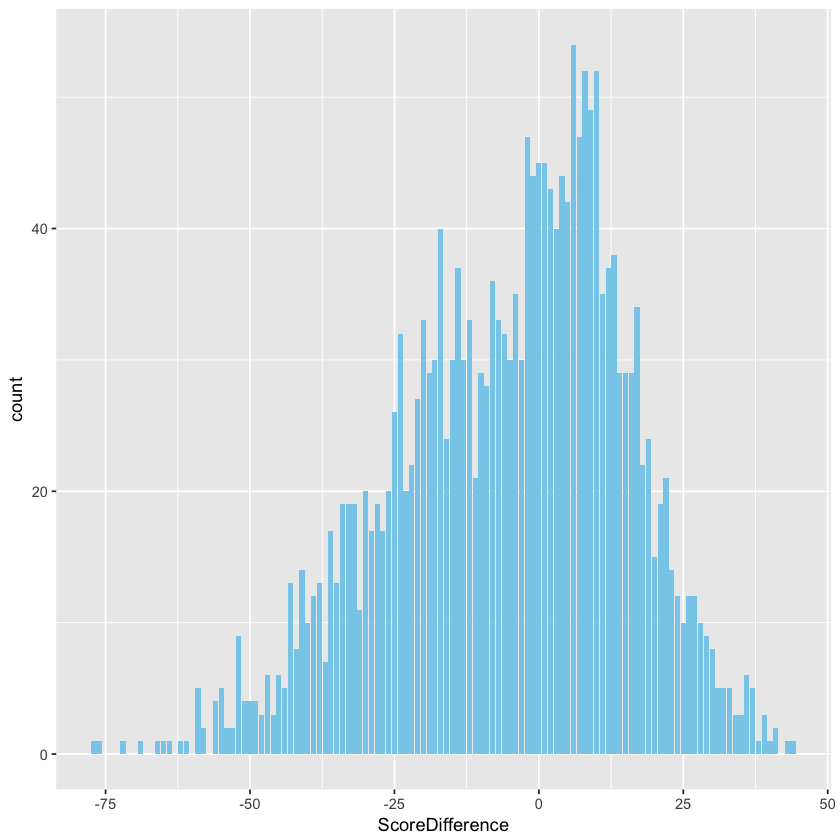

In [9]:
ggplot(MovieTable)+geom_bar(aes(x=ScoreDifference), fill = "sky blue", position = "dodge", stat = "count")

[1] 0.9685098

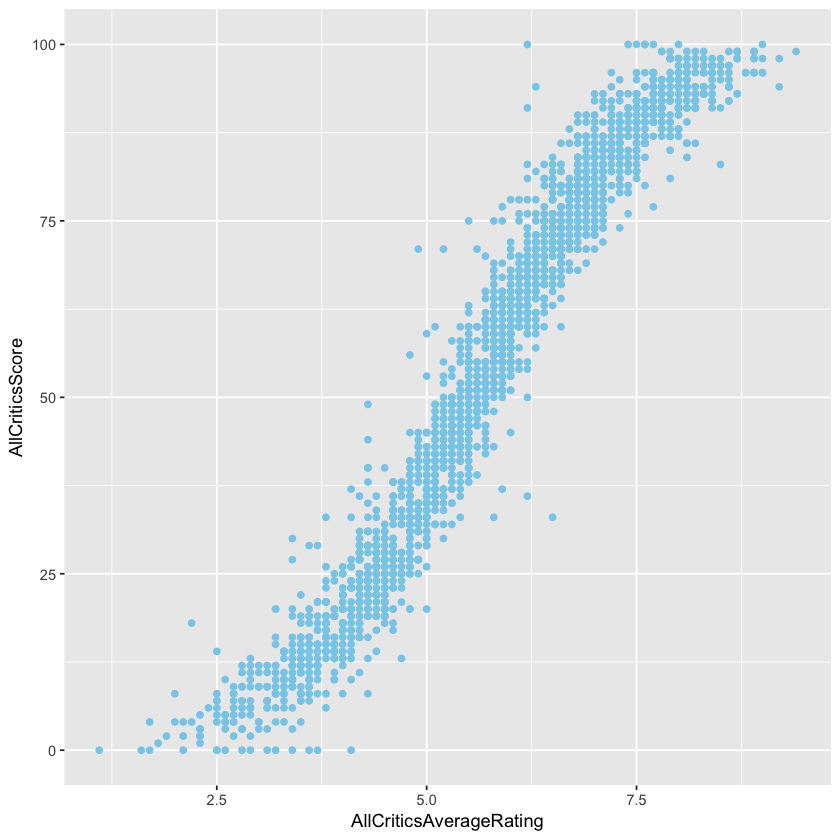

In [10]:
ggplot(MovieTable, aes(y = AllCriticsScore, x =  AllCriticsAverageRating) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")
cor(MovieTable$AllCriticsScore, MovieTable$ AllCriticsAverageRating)

[1] 0.7533917

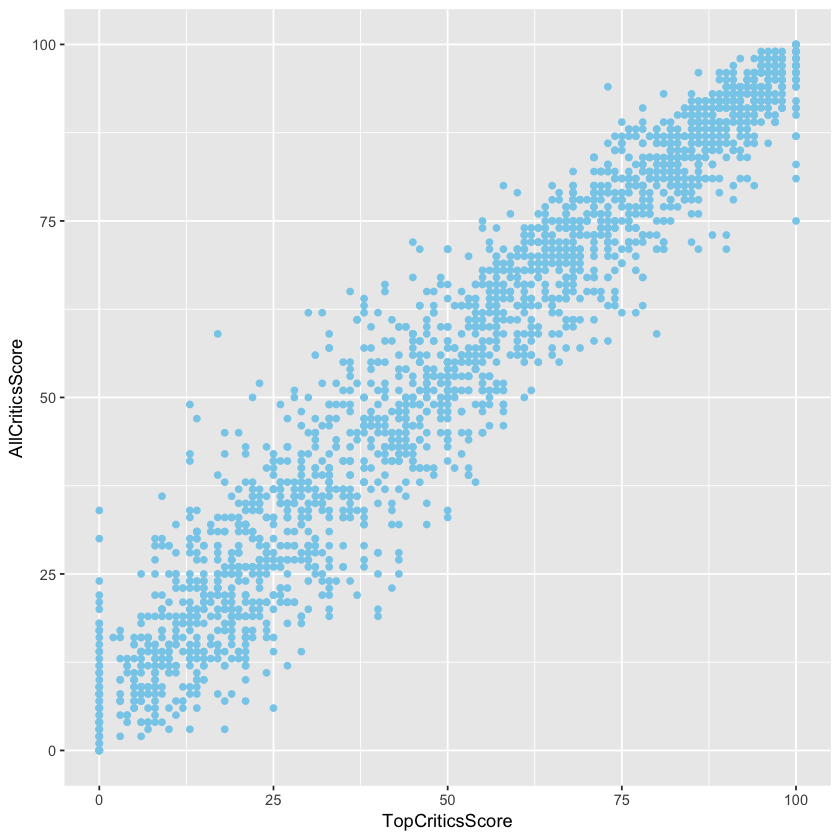

In [11]:
ggplot(MovieTable, aes(y = AllCriticsScore, x = TopCriticsScore) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")
cor(MovieTable$AllCriticsScore, MovieTable$ScoreDifference)

[1] 0.3851267

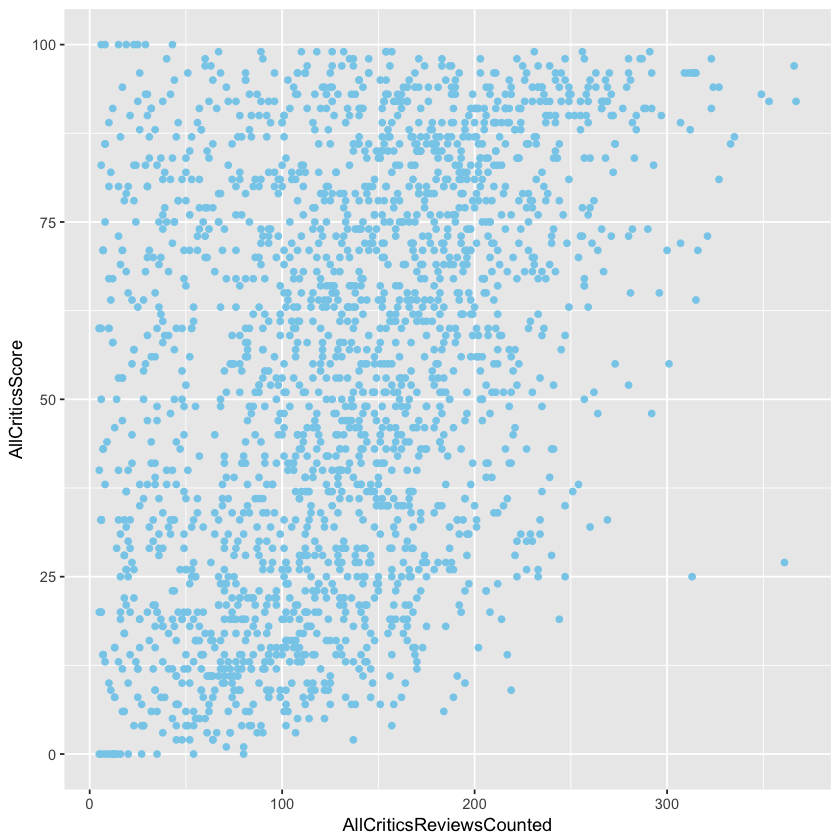

In [12]:
ggplot(MovieTable, aes(y = AllCriticsScore, x = AllCriticsReviewsCounted) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")
cor(MovieTable$AllCriticsScore, MovieTable$AllCriticsReviewsCounted)

Top Critics and all critics highly correlated, redundant to analyze both. All critics score and number of ratings uncorrelated, strictly better to remove rows with a low number of ratings.

[1] 0.7533917

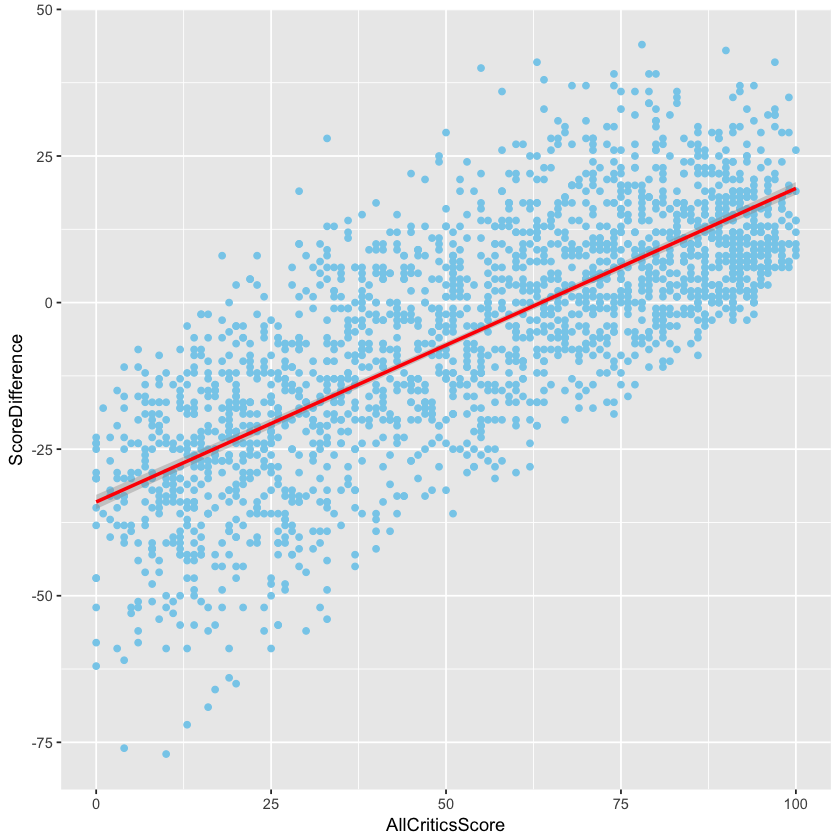

In [13]:
ggplot(MovieTable, aes(y = ScoreDifference, x = AllCriticsScore) ) +
  geom_point(colour = "sky blue") + geom_smooth(colour = "red", method=lm)
cor(MovieTable$AllCriticsScore, MovieTable$ScoreDifference)

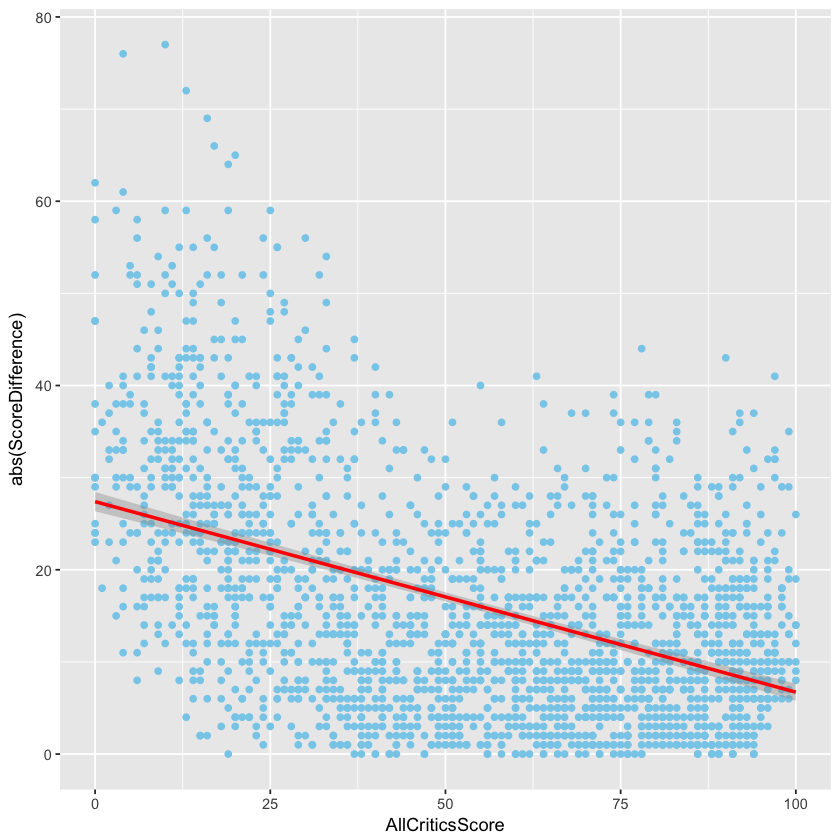

In [14]:
ggplot(MovieTable, aes(y = abs(ScoreDifference), x = AllCriticsScore) ) +
  geom_point(colour = "sky blue") + geom_smooth(colour = "red", method=lm)

lower scored movies are more "controversial"

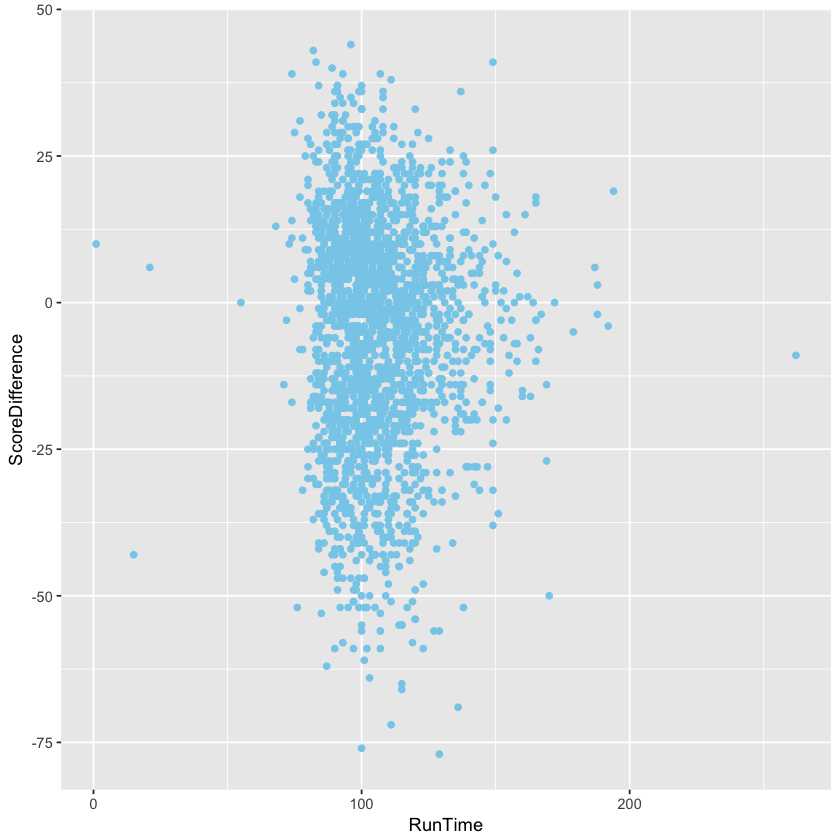

In [15]:
ggplot(MovieTable, aes(y = ScoreDifference, x = RunTime) ) +
  geom_point(na.rm = TRUE, colour = "sky blue") 

no clear correlation between runtime and score difference

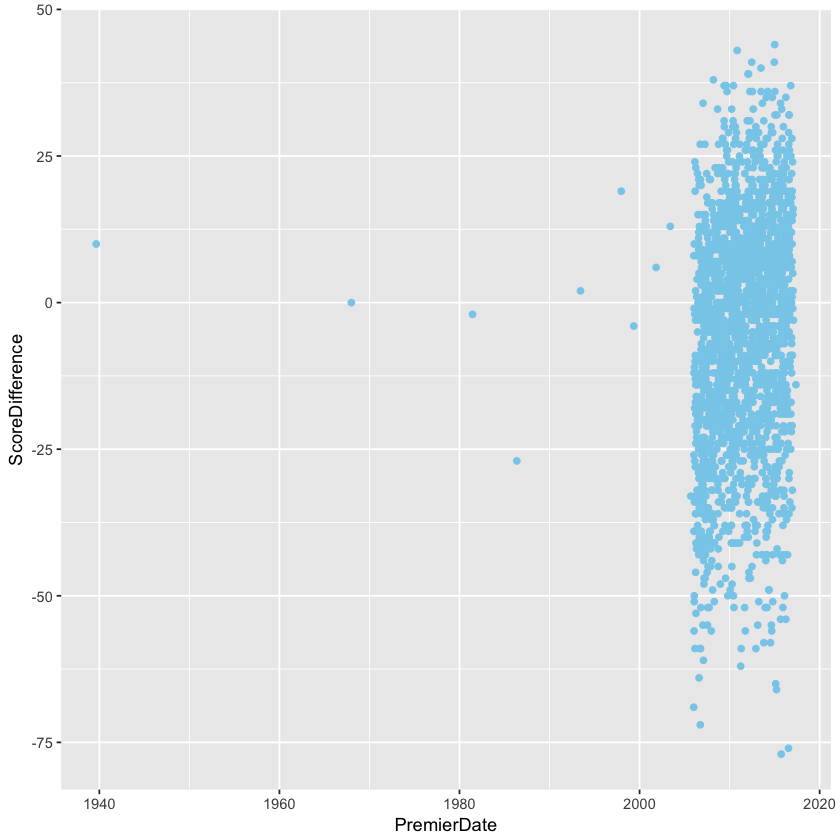

In [16]:
ggplot(MovieTable, aes(y = ScoreDifference, x = PremierDate) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")

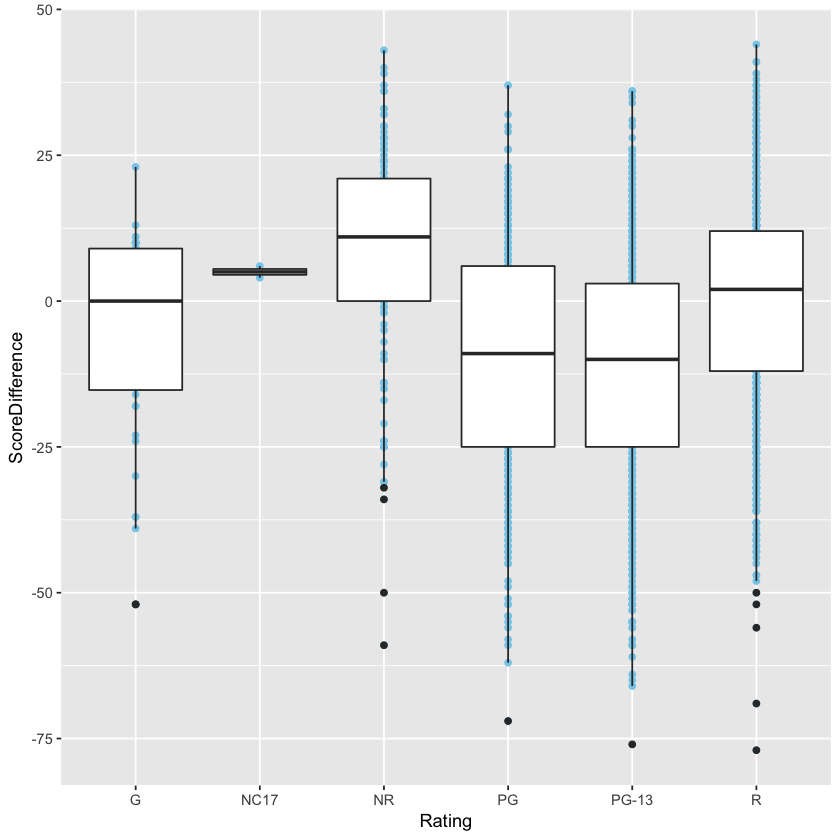

In [17]:
ggplot(MovieTable, aes(y = ScoreDifference, x = Rating) ) +
  geom_point(na.rm = TRUE, colour = "sky blue") + geom_boxplot()

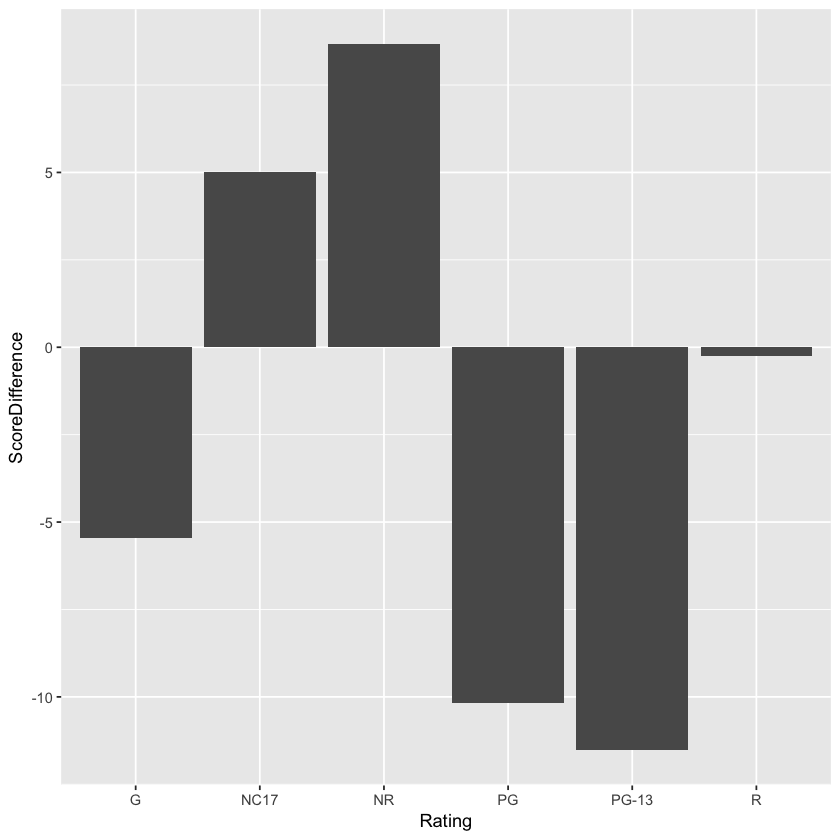

In [18]:
ggplot(MovieTable, aes(y = ScoreDifference, x = Rating) ) +
  stat_summary(fun.y=mean, geom="bar",position=position_dodge(1))

In [ ]:
ggplot(MovieTable, aes(y = ScoreDifference, x = BoxOffice) ) +
  geom_point(na.rm = TRUE, colour = "sky blue")

In [ ]:
ggplot(MovieTable, aes(x = BoxOffice) ) + geom_histogram(na.rm = TRUE)

In [81]:
GenreTable = MovieTable[, (names(MovieTable) %in% Genres)]
GenreTable = cbind(GenreTable, MovieTable$ScoreDifference)


In [86]:
aql <- melt(GenreTable, id.vars = c("ActionAdventure", "Animation", "Comedy", "Kids", "SciFi", 
          "Horror", "Romance", "Drama", "ArtHouse", "Mystery", "Musical", "Documentary", "Western"),
    variable.name = "Genres"
)

In [88]:
aql$ggplot(aql, aes(y = ScoreDifference, x = Genres) ) +
  geom_point(na.rm = TRUE, colour = "sky blue") + geom_boxplot()

ERROR: Error in eval(expr, envir, enclos): attempt to apply non-function
